In [1]:
import argparse
import os
import glob

#load data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, utils, datasets

from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import SYNet
import time
import copy
import csv


In [2]:
concrete_cement_type = [1.0, 0.0, 0.0, 0.0, 0.0]
healthy_metal_type = [0.0, 1.0, 0.0, 0.0, 0.0]
incomplete_type = [0.0, 0.0, 1.0, 0.0, 0.0]
irregular_metal_type = [0.0, 0.0, 0.0, 1.0, 0.0]
other_type = [0.0, 0.0, 0.0, 0.0, 1.0]

In [3]:
concrete_cement_images = glob.glob('./training/unmasked/concrete_cement/*.png')
a= [concrete_cement_type] * len(concrete_cement_images)

healthy_metal_images = glob.glob('./training/masked/healthy_metal/*.png')
b=[healthy_metal_type] * len(healthy_metal_images)

incomplete_images = glob.glob('./training/masked/incomplete/*.png')
c=[incomplete_type] * len(incomplete_images)

irregular_metal_images = glob.glob('./training/masked/irregular_metal/*.png')
d=[irregular_metal_type]  * len(irregular_metal_images)

other_images = glob.glob('./training/masked/other/*.png')
e=[other_type] * len(other_images)

train_images = [concrete_cement_images, healthy_metal_images, incomplete_images, irregular_metal_images, other_images]
train_images_labels = [a,b,c,d,e]

train_images = [item for sublist in train_images for item in sublist]
train_images_labels = [item for sublist in train_images_labels for item in sublist]

test_images = list(pd.read_csv("submission_format.csv",index_col=0).index.values)
test_images = ['./testing/masked/' + str(i) + '.png' for i in test_images]
#test_images = glob.glob('./testing/masked/*.png')

In [4]:
test_images[0]

'./testing/masked/7a4d630a.png'

In [5]:
class RoofDataset(Dataset):
    def __init__(self, train_image_paths, train_images_labels,transform=None):
        self.image_paths = train_image_paths
        self.image_labels = train_images_labels
        self.transform=transform
        
    def __getitem__(self, index):
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        
        material_type = torch.LongTensor(self.image_labels[index])
        return roof_image, material_type    
    
    def __len__(self):
        return len(self.image_paths)

In [6]:
class RoofTestDataset(Dataset):
    def __init__(self, image_paths,transform=None):
        self.image_paths = image_paths
        self.transform=transform
        
    def __getitem__(self, index):
        roof_id = self.image_paths[index].replace('./testing/masked/','').replace('.png','')
        #print("Replaced:", roof_id)
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        return roof_image, roof_id
    
    def __len__(self):
        return len(self.image_paths)

In [7]:
transformations = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
train_dataset = RoofDataset(train_images, train_images_labels,transformations)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0
                         )

test_dataset = RoofTestDataset(test_images, transformations)
test_loader = DataLoader(test_dataset,
                        batch_size = 1,
                        num_workers = 0)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/yeoncham/.cache/torch/checkpoints/vgg16-397923af.pth
4.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

10.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

16.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_ra

Train Epoch: 1 [320/14870 (2%)]	Loss: 1.443462
Train Epoch: 1 [640/14870 (4%)]	Loss: 1.186060
Train Epoch: 1 [960/14870 (6%)]	Loss: 1.268362
Train Epoch: 1 [1280/14870 (9%)]	Loss: 1.068733
Train Epoch: 1 [1600/14870 (11%)]	Loss: 1.068135
Train Epoch: 1 [1920/14870 (13%)]	Loss: 1.170733
Train Epoch: 1 [2240/14870 (15%)]	Loss: 1.102420
Train Epoch: 1 [2560/14870 (17%)]	Loss: 0.984315
Train Epoch: 1 [2880/14870 (19%)]	Loss: 0.922239
Train Epoch: 1 [3200/14870 (22%)]	Loss: 1.192589
Train Epoch: 1 [3520/14870 (24%)]	Loss: 0.948540
Train Epoch: 1 [3840/14870 (26%)]	Loss: 0.996597
Train Epoch: 1 [4160/14870 (28%)]	Loss: 1.097415
Train Epoch: 1 [4480/14870 (30%)]	Loss: 1.046261
Train Epoch: 1 [4800/14870 (32%)]	Loss: 0.935132
Train Epoch: 1 [5120/14870 (34%)]	Loss: 0.902382
Train Epoch: 1 [5440/14870 (37%)]	Loss: 0.892084
Train Epoch: 1 [5760/14870 (39%)]	Loss: 0.836144
Train Epoch: 1 [6080/14870 (41%)]	Loss: 0.791853
Train Epoch: 1 [6400/14870 (43%)]	Loss: 0.779827
Train Epoch: 1 [6720/14870 

Train Epoch: 4 [8960/14870 (60%)]	Loss: 0.576244
Train Epoch: 4 [9280/14870 (62%)]	Loss: 0.659869
Train Epoch: 4 [9600/14870 (65%)]	Loss: 0.618921
Train Epoch: 4 [9920/14870 (67%)]	Loss: 0.767434
Train Epoch: 4 [10240/14870 (69%)]	Loss: 0.631697
Train Epoch: 4 [10560/14870 (71%)]	Loss: 0.321102
Train Epoch: 4 [10880/14870 (73%)]	Loss: 0.785483
Train Epoch: 4 [11200/14870 (75%)]	Loss: 0.582940
Train Epoch: 4 [11520/14870 (77%)]	Loss: 0.484923
Train Epoch: 4 [11840/14870 (80%)]	Loss: 0.745135
Train Epoch: 4 [12160/14870 (82%)]	Loss: 0.970345
Train Epoch: 4 [12480/14870 (84%)]	Loss: 0.692698
Train Epoch: 4 [12800/14870 (86%)]	Loss: 0.675494
Train Epoch: 4 [13120/14870 (88%)]	Loss: 0.398205
Train Epoch: 4 [13440/14870 (90%)]	Loss: 0.541806
Train Epoch: 4 [13760/14870 (92%)]	Loss: 0.428989
Train Epoch: 4 [14080/14870 (95%)]	Loss: 0.541394
Train Epoch: 4 [14400/14870 (97%)]	Loss: 0.648095
Train Epoch: 4 [14720/14870 (99%)]	Loss: 0.392346
Train Epoch: 5 [0/14870 (0%)]	Loss: 0.432846
Train Epo

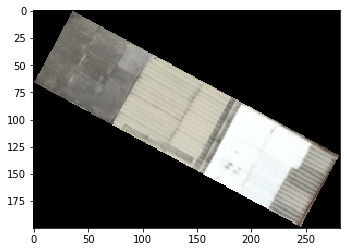

In [8]:
model = SYNet.VGG_Baseline()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
#criterion = torch.nn.functional.softmax(output)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        _, idx = torch.max(target,1)
        loss = criterion(output, idx)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

for epoch in range(1,6):
    train(epoch)

In [9]:
torch.save(model.state_dict(), './models/vgg16_5_0.0001.pt')

In [17]:
model.load_state_dict(torch.load('./models/vgg16_5_0.0001.pt'))

<All keys matched successfully>

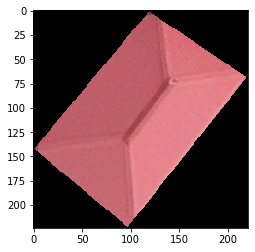

In [11]:
for p in model.parameters():
    if p.grad is not None:
        del p.grad
torch.cuda.empty_cache()

test_id = []
test_label = []
list_from_labelTensor = []

def test():
    model.eval()
    predictions = []
    for data, roof_id in test_loader:
        replaced_roof_id = roof_id[0]
        test_id.append(replaced_roof_id)
       # print(replaced_roof_id)
        data = data.cuda(async=True) # On GPU
        output = model(data)
        list_from_labelTensor = torch.nn.functional.softmax(output, dim=1).tolist()
        #print(replaced_roof_id, list_from_labelTensor)
        test_label.append(list_from_labelTensor)
        
        
test()
#print(len(test_id), len(test_label))


In [12]:
print(len(test_id), len(test_label))


7325 7325


In [13]:
submission_dict = {}
submission_dict['id'] = []
submission_dict['concrete_cement'] = [] 
submission_dict['healthy_metal'] = []
submission_dict['incomplete'] = []
submission_dict['irregular_metal'] = []
submission_dict['other'] = []

for i, j in zip(test_id, test_label):
    submission_dict['id'].append(i)
    submission_dict['concrete_cement'].append(j[0][0])
    submission_dict['healthy_metal'].append(j[0][1])
    submission_dict['incomplete'].append(j[0][2])
    submission_dict['irregular_metal'].append(j[0][3])
    submission_dict['other'].append(j[0][4])
    

In [14]:
pd.DataFrame(submission_dict).to_csv("submission_result.csv")
sub_df = pd.read_csv("submission_result.csv",index_col=0)

In [15]:
sub_df

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.000076,0.987850,0.000243,0.008959,0.002872
1,7a4bbbd6,0.000030,0.968840,0.000593,0.028142,0.002395
2,7a4ac744,0.000056,0.960791,0.000677,0.036113,0.002363
3,7a4881fa,0.001685,0.319046,0.017646,0.650696,0.010926
4,7a4aa4a8,0.000331,0.918304,0.002416,0.075295,0.003654
...,...,...,...,...,...,...
7320,7a4f3ff4,0.001504,0.540068,0.014628,0.435902,0.007898
7321,7a4fc578,0.001198,0.929758,0.003991,0.049812,0.015240
7322,7a4ac7b2,0.000316,0.884561,0.003090,0.105687,0.006346
7323,7a47e25e,0.001560,0.553161,0.022193,0.408097,0.014990


In [16]:
sub_df.to_csv("./submission_result.csv", index = False)